In [25]:
import torch
import numpy

#### What exactly an LSTM returns and shapes the data

In [26]:
input_tensor = torch.tensor([[[1., 1., 1.],
                              [2., 2., 2.],
                              [3., 3., 3.]]])
input_size = input_tensor.size(-1)
hidden_size = 3
lstm = torch.nn.LSTM(input_size=input_size,
                     hidden_size=hidden_size,
                     num_layers=1,
                     batch_first=True)
output, (h_n, c_n) = lstm(input_tensor)
output, (h_n, c_n)

(tensor([[[0.1551, 0.0280, 0.2970],
          [0.2414, 0.0114, 0.4434],
          [0.2473, 0.0024, 0.5089]]], grad_fn=<TransposeBackward0>),
 (tensor([[[0.2473, 0.0024, 0.5089]]], grad_fn=<StackBackward0>),
  tensor([[[0.3067, 0.0430, 0.6086]]], grad_fn=<StackBackward0>)))

In [27]:
print(f"output size: {output.size()}, (batch_size, seq_len, H_out)")
print(f"h_n size:    {h_n.size()}, (batch_size, num_layers, H_out)")
print(f"c_n size:    {c_n.size()}, (num_layers, batch_size, H_cell)")

output size: torch.Size([1, 3, 3]), (batch_size, seq_len, H_out)
h_n size:    torch.Size([1, 1, 3]), (batch_size, num_layers, H_out)
c_n size:    torch.Size([1, 1, 3]), (num_layers, batch_size, H_cell)


In [28]:
input_tensor = torch.tensor([[[1., 1., 1.],
                              [2., 2., 2.],
                              [3., 3., 3.],
                              [4., 4., 4.]]])

In [29]:
x = input_tensor
x = x.permute(0, 2, 1)
x

tensor([[[1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.]]])

## Setting generator seeds

In [30]:
%load_ext autoreload
%autoreload

from architectures import COTGAN
from utils import DatasetSinus, log_visualizations
from trainer import cotgan_trainer, cotgan_generator
from metrics import *
import numpy as np
import torch
import matplotlib.pyplot as plt

seed = 42
alpha = 0.7
noise = 0
np.random.seed(seed)
torch.manual_seed(seed)

device = "cpu"
trainset = DatasetSinus(num=6*12, seq_len=25, alpha=alpha, noise=noise, device=device)

sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]


In [31]:
trainset[:6][0].shape

torch.Size([25, 3])

In [32]:
params = {
    "model_name": "model_cotgan.pt",
    "n_epochs": 1,
    "l_rate": 0.001, # for both D and G
    "batch_size": 32,
    "dis_rnn_num_layers": 1,
    #"dis_rnn_hidden_dim": 20,
    "gen_rnn_num_layers": 2,
    "gen_rnn_hidden_dim": 5,
    "hidden_dim": 10, # generator: hidden dim in FC, discriminator: filters in Convolution
    "num_hidden_layers": 2, # generator fully-connected layers

    "scaling_coef": 1.0, # distance scaling (TODO(Not implemented))
    "sinkhorn_eps": 0.8, # epsilon regularizer
    "sinkhorn_l":   100, # sinkhorn calculation iterations
    "reg_lam":      10.0, # martingale penalty coefficient

    "Z_dim": 20,
    "optimizer": "Adam", # RMSprop, Adam
    "beta1": 0.5,
    "beta2": 0.9,
    "dataset": "sines",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "device": device,
}

model = COTGAN(params)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [33]:
z1 = torch.randn(6,params["max_seq_len"], params["Z_dim"])
z2 = torch.randn(6,params["max_seq_len"], params["Z_dim"])

x1 = trainset[:6][0]
x2 = trainset[6:12][0]

NameError: name 'params' is not defined

In [34]:
model(z1,z2,x1,x2, obj="discriminator")

NameError: name 'model' is not defined

In [35]:
x1.size()

NameError: name 'x1' is not defined

In [36]:
import torch
batch_size = 6
seq_len = 25
dim_size = 3
x = torch.randn(batch_size, seq_len, dim_size)

In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# def create_sin_wave but writte with torch
def create_sin_wave(spatial_len=25, seq_len=10):
    e = torch.rand(1) * 0.6
    x = torch.linspace(0, 1, spatial_len) + e
    time = torch.linspace(0, 0.3, seq_len)
    amplitude = 0.5
    freq = 1.5
    y = amplitude * torch.sin( 2 * np.pi * freq * (x + time[:, None])) + 0.5
    #plt.plot(y.T[:,:]);
    return y
create_sin_wave(spatial_len=50, seq_len=25);

In [39]:
batch_size = 32
hidden_dim = 10
rnn_hidden_dim = 15
max_seq_len = 25
spatial_len = 50
data = torch.stack([create_sin_wave(spatial_len=spatial_len, seq_len=max_seq_len) for _ in range(batch_size)])
data.size()

torch.Size([32, 25, 50])

In [40]:
# DISCRIMINATOR
disc = torch.nn.Sequential(torch.nn.Conv1d(in_channels=1, out_channels=hidden_dim, kernel_size=5, stride=1, padding=2),
                           torch.nn.BatchNorm1d(hidden_dim),
                           torch.nn.ReLU(),
                           torch.nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim*2, kernel_size=5, stride=1, padding=2),
                           torch.nn.BatchNorm1d(hidden_dim*2),
                           torch.nn.ReLU(),
                           )

rnn = torch.nn.GRU(input_size=hidden_dim * 2 * spatial_len, hidden_size=rnn_hidden_dim, num_layers=1, batch_first=True)

In [41]:
# forward pass
batch_size = 32
max_seq_len = 25
spatial_len = 50
data = torch.rand(batch_size, max_seq_len, spatial_len)
print(f"input size: \t\t{data.size()}")
x = data.view(batch_size*max_seq_len, 1, -1)
print(f"input size: \t\t{x.size()}")
x = disc(x)
print(f"disc output size:   {x.size()}")
x = x.view(batch_size, max_seq_len, -1)
print(f"rnn input size: \t{x.size()}")
x, _ = rnn(x)
print(f"rnn output size: \t{x.size()}")



input size: 		torch.Size([32, 25, 50])
input size: 		torch.Size([800, 1, 50])
disc output size:   torch.Size([800, 20, 50])
rnn input size: 	torch.Size([32, 25, 1000])
rnn output size: 	torch.Size([32, 25, 15])


In [42]:
max_seq_len = 25
x = torch.randn(batch_size, max_seq_len , spatial_len)
hidden_dim = 20
m1 = torch.nn.Conv1d(in_channels=1, out_channels=hidden_dim, kernel_size=5, stride=1, padding=2)
m2 = torch.nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim*2, kernel_size=5, stride=1, padding=2)
x = x.view(batch_size*max_seq_len, 1, -1)
x = m1(x)
x = m2(x)
#x.size()
print(x.size())
x = x.view(batch_size, max_seq_len, -1)
print(x.size())
2000 == 20 * 50 * 2

torch.Size([800, 40, 50])
torch.Size([32, 25, 2000])


True

In [43]:
# GENEARATOR
batch_size = 16
Z_dim = 10
gen_rnn_hidden_dim = 25
gen_rnn = torch.nn.GRU(input_size=Z_dim,
                        hidden_size=gen_rnn_hidden_dim,
                        num_layers=1,
                        batch_first=True)
gen_rnn2 = torch.nn.GRU(input_size=gen_rnn_hidden_dim,
                        hidden_size=gen_rnn_hidden_dim * 2,
                        num_layers=1,
                        batch_first=True)
linear = torch.nn.Linear(in_features=gen_rnn_hidden_dim * 2, out_features=1)

In [44]:
x = torch.randn(batch_size, max_seq_len, Z_dim)
print(f"input size: \t\t\t{x.size()}")
x, _ = gen_rnn(x)
print(f"gen_rnn output size: \t{x.size()}")
x, _ = gen_rnn2(x)
print(f"gen_rnn2 output size: \t{x.size()}")
x = linear(x)
print(f"linear output size: \t{x.size()}")


input size: 			torch.Size([16, 25, 10])
gen_rnn output size: 	torch.Size([16, 25, 25])
gen_rnn2 output size: 	torch.Size([16, 25, 50])
linear output size: 	torch.Size([16, 25, 1])


In [45]:
def grid(P=20, M=100):
    dx = P/M
    x = np.linspace(0, P-dx, M)
    return x, dx

In [46]:
c = 1.5 # the speed, and two times the height of the wave
P = 20 # period
M = 100 # number of spatial points
x, dx = grid(P, M)
x += P/4 # start the wave at x=5
sech = lambda a: 1/np.cosh(a) # sech isn't defined in NumPy
u_soliton = lambda x, t: 1/2*c*sech(np.abs((x-c*t) % P - P/2))**2

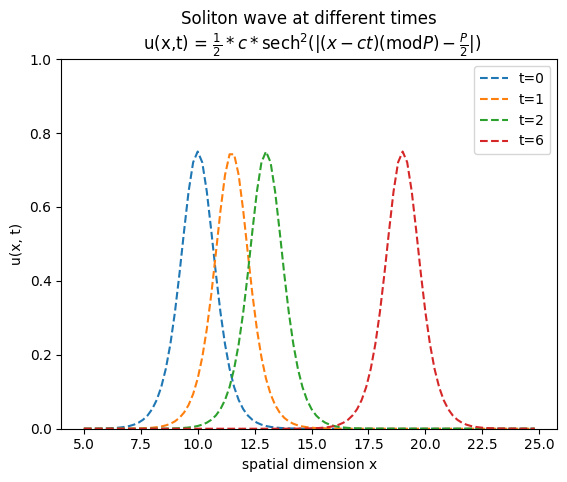

In [47]:
plt.plot(x, u_soliton(x, 0), '--', label="t=0")
plt.plot(x, u_soliton(x, 1), '--', label="t=1")
plt.plot(x, u_soliton(x, 2), '--', label="t=2")
plt.plot(x, u_soliton(x, 6), '--', label="t=6")
plt.ylim(0, 1)
u_t_x = r"u(x,t) = $\frac{1}{2} *c* \mathrm{sech}^2 (| (x - c t) (\mathrm{mod}P)-\frac{P}{2}|)$"
plt.title(f"Soliton wave at different times\n {u_t_x}")
plt.xlabel("Spatial dimension x")
plt.ylabel("u(x, t)")
plt.legend()

Jeg har lagd et nytt dataset med Solitons (en enkel bølge som forflytter seg over tid og som en analytisk løsning til KdV) der jeg kan spesifisere høyde på bølgen og hvor mange tidssteg jeg ønsker å ha med. Eksempelet på bilde er ett eksemplar fra datasettet der blå bølge indikerer bølgen ved tidspunkt t=0 og de andre bølgene/fargene i senere tidspunkt.
Hvis jeg vil kan dette animeres ved å vise bølgen for hvert enkelt tidspunk og ikke "alle" på en gang som vist i eksempelet.
Datasettet inneholder alle bølgehøyder fra 0.25 til 1 med 10 tidssteg jevt fortdelt.

Trente en ny GAN på dette datasettet og fikk overaskende gode resultater ved lite testing, som er motiverende. Plotten med 9 bilder er noen eksempler
, hvor vi kan se at den har klart å produsere relativt glatte bølger som er jevt fortelt. Den vanskeligste oppgaven er å produsere en uniform fordeling av forskjellige bølgehøyder (c), som den er på sporet av. Interessant om dette faktisk er forventet fra oss selv om vi sampler støy (Z) fra en normal fordeling (kanskje mer forventet hvis Z er uniform fordeling?).

Slik er fordelingen for bølgehøyde * 2, som i datasettet er uniformt fordelte mellom 0.5 og 2. (bølgehøyde * 2 fordi vi bruker c som en parameter for å definere bølgen, og c = 2h, hvor h er bølgehøyden)

Det viktigste er at den har klart å forstå produsere glatte bølger over noen tidssteg med middels høy romoppløsning (x) og noen et par tidssteg. Skal kjøre samme eksperiment med flere tidssteg nå.



In [743]:
# create a dataset of soliton waves

class SolitonDataset(torch.utils.data.Dataset):
    def __init__(self, n_samples, P, t_range, c_range, spatial_len=50, t_steps=25):
        self.t_range = t_range # [0, 6]
        self.c_range = c_range #[0.5, 2]
        self.P = P # period
        self.n_samples = n_samples
        self.t_steps = t_steps
        self.spatial_len = spatial_len # M
        self.data = self.create_soliton_dataset_torch()

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.data[idx]

    def create_soliton_dataset_torch(self):
        sech = lambda a: 1/torch.cosh(a) # sech isn't defined in NumPy
        u_soliton_t = lambda x, t, c, P: 1/2*c*sech(torch.abs((x-c*t) % P - P/2))**2

        def grid(P, M):
            dx = P/M
            x = torch.linspace(0, P-dx, M)
            return x, dx

        data = torch.zeros((self.n_samples, self.t_steps, self.spatial_len))
        # random speed =c
        c_arr = torch.FloatTensor(self.n_samples).uniform_(self.c_range[0], self.c_range[1])
        t = torch.linspace(t_range[0], t_range[1], self.t_steps)
        x, dx = grid(self.P, self.spatial_len)
        x += P/4 # start the wave at x=5
        for i in range(self.n_samples):
            c = c_arr[i]
            u = u_soliton_t(x, t[:, None], c, self.P)
            data[i] = u
        return data


In [744]:
# Global parameters [min, max]
c_range = [0.5, 2] # torch.uniform(0.5, 2)
t_range = [0, 6] # torch.linspace(0, 3, t_steps)
t_steps = 25
dataset = SolitonDataset(n_samples=100, P=20, t_range=t_range, c_range=c_range, spatial_len=M, t_steps=t_steps)

In [745]:
dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=16,
        shuffle=True
    )

torch.Size([16, 25, 50])


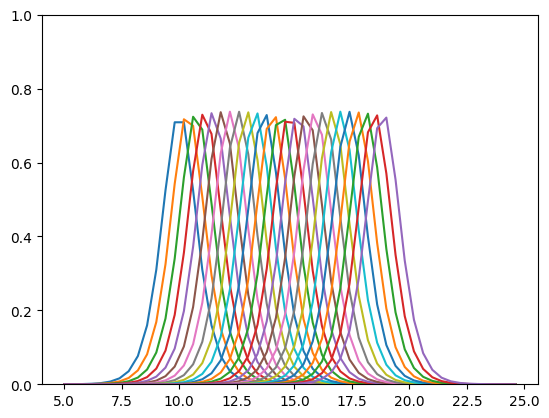

In [785]:
for X_mb in dataloader:
    print(X_mb.size())
    plt.plot(x, X_mb[0].T)
    plt.ylim(0, 1)
    break

## Generator with GRU and Conv1dTranspose
- Not sure if this works yet

In [863]:

import torch
import torch.nn as nn
batch_size = 16
max_seq_len = 25
Z_dim = 10

gen_rnn_hidden_dim = 64
gen_rnn_num_layers = 1

# real data shapes
P = 10
spatial_len = 50
t_steps = 25

gen_rnn = nn.GRU(input_size=Z_dim,
                hidden_size=gen_rnn_hidden_dim,
                num_layers=1,
                batch_first=True)
# For FC layers
input_hidden = gen_rnn_hidden_dim
if gen_rnn_num_layers > 1:
    input_hidden = gen_rnn_hidden_dim * 2
    gen_rnn2 = nn.GRU(input_size=gen_rnn_hidden_dim,
                    hidden_size=gen_rnn_hidden_dim * 2,
                    num_layers=1,
                    batch_first=True)

gen_conv = nn.ConvTranspose1d(in_channels=1,
                            out_channels=5,
                            kernel_size=3,
                            stride=1,
                            padding=1,
                            bias=True,
                            )

# define data and forward pass
data = torch.rand(batch_size, max_seq_len, Z_dim)
x, _ = gen_rnn(data)
print(x.size())
x = data.view(batch_size * max_seq_len, 1, -1)
x = gen_conv(x)
x.view(batch_size, max_seq_len, -1).size()

torch.Size([16, 25, 64])

## PCA and UMAP on Soliton data

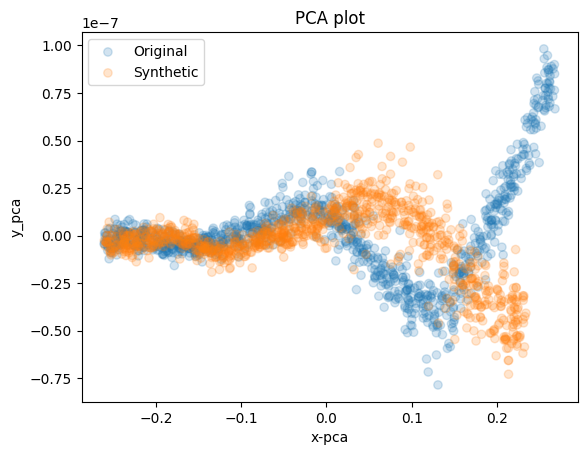

In [19]:
from trainer import create_dataset
from utils import visualization, DatasetSoliton
P = 20
M = 100
t_steps = 50
n_samples = 1000
real_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 2], spatial_len=M, t_steps=t_steps)[:n_samples]
fake_data = DatasetSoliton(n_samples, P=P, t_range=[0, 5], c_range=[0.5, 1.9], spatial_len=M, t_steps=t_steps)[:n_samples]

visualization(real_data, fake_data, 'pca');

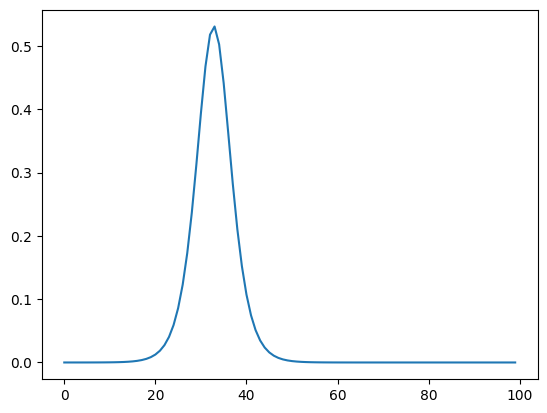

In [20]:
plt.plot(real_data[7,12])

In [14]:
%%time
# Get height of the first wave
c_values1 = real_data[:, 0,:].max(dim=1)[0]
c_values2 = fake_data[:, 0,:].max(dim=1)[0]


def two_sample_kolmogorov_smirnov(x, y):
    from scipy.stats import ks_2samp
    """Two sample Kolmogorov-Smirnov test which calculates if the samples are being drawn from the same distribution,
         p-value less than 0.05 means that the samples are not from the same distribution.
    Args:
        x (torch.Tensor): (n_samples, )
        y (torch.Tensor): (n_samples, )
    :returns: p-value
    """
    return ks_2samp(x, y)[1]

prob = two_sample_kolmogorov_smirnov(c_values1, c_values2)
prob

CPU times: user 3.04 ms, sys: 2.29 ms, total: 5.33 ms
Wall time: 2.76 ms


0.0006029005665324465

(0.5, 2.0)

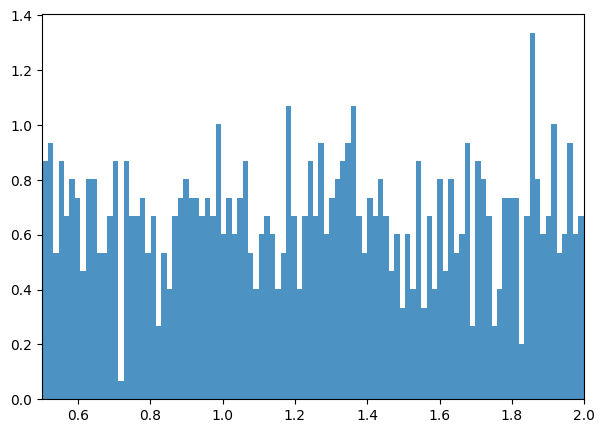

In [16]:
fig = plt.figure(figsize=(7, 5))
plt.hist(2*c_values1, bins=100, density=True, alpha=0.8)
plt.xlim(0.5, 2)

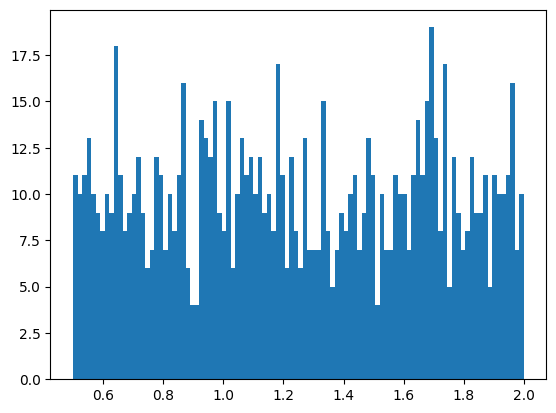

In [11]:
import torch
import matplotlib.pyplot as plt
device = "mps"
u = torch.rand(1000)
c_range = torch.tensor([0.5, 2])
c = torch.rand(1000) * (c_range[1] - c_range[0]) + c_range[0]
plt.hist(c, bins=100);

In [1]:
real_data[:1, :, :].max(dim=2)[0].shape, c_values1[0]

NameError: name 'real_data' is not defined

In [1026]:
def mae_height_diff(data):
    """Mean absolute error between the max height of the first wave and all other preceding waves
    Args:
        data (torch.Tensor): (n_samples, t_steps, spatial_len)
    """
    if type(data) != torch.Tensor:
        raise TypeError('Data must be a torch.Tensor')
    return (data.max(dim=2)[0] - data[:, 0, :, None].max(dim=1)[0]).abs().mean()

(real_data[:, :, :].max(dim=2)[0] - c_values1[:, None]).abs().mean()

tensor(0.0020)

In [1027]:
mae_height_diff(real_data)

tensor(0.0020)

## Approximated Sinkhorn distance investigation
Reshaping the data to be (n_samples * t_steps, spatial_len) seemed to be most stable

In [1178]:
from metrics import sw_approx, sinkhorn_distance
from utils import visualization, DatasetSoliton
P = 20
M = 100
t_steps = 50
n_samples = 1000
real_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 2], spatial_len=M, t_steps=t_steps)[:n_samples]
fake_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 1], spatial_len=M, t_steps=t_steps)[:n_samples]


b_t_m: 0.003331566695123911, bt_m: 0.00015247143164742738, b_tm: 0.00324659189209342
CPU times: user 18.6 s, sys: 3.42 s, total: 22 s
Wall time: 16.2 s


{'whiskers': [<matplotlib.lines.Line2D at 0x29ab44fa0>,
 'caps': [<matplotlib.lines.Line2D at 0x298ca6bb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x29ab44c70>,
 'medians': [<matplotlib.lines.Line2D at 0x280bff310>,
 'fliers': [<matplotlib.lines.Line2D at 0x280bff520>,
 'means': []}

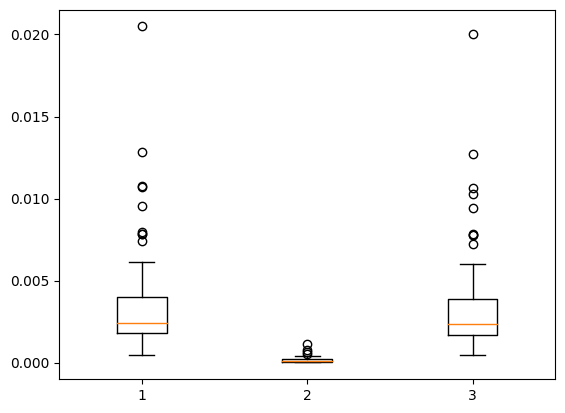

In [1190]:
%%time
#real_data = torch.randn(5000, 3)
#fake_data = torch.randn(5000, 3)
#sw_approx(real_data, fake_data), \
n = 100
b_t_m = torch.zeros(n)
bt_m = torch.zeros(n)
b_tm = torch.zeros(n)


for i in range(n):
    real_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 2], spatial_len=M, t_steps=t_steps)[:n_samples]
    fake_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 2], spatial_len=M, t_steps=t_steps)[:n_samples]
    b_t_m[i] = sw_approx(real_data, fake_data)
    bt_m[i] = sw_approx(real_data.view(n_samples*t_steps, -1 ), fake_data.view(n_samples*t_steps, -1 ))
    b_tm[i] = sw_approx(real_data.view(-1, t_steps* M ), fake_data.view(-1, t_steps* M ))
bt_m_0 = bt_m
print(f"b_t_m: {b_t_m.mean()}, bt_m: {bt_m.mean()}, b_tm: {b_tm.mean()}")
plt.boxplot([b_t_m, bt_m, b_tm]);

b_t_m: 0.0992768406867981, bt_m: 0.003138594562187791, b_tm: 0.09861902892589569
CPU times: user 19.1 s, sys: 3.43 s, total: 22.5 s
Wall time: 16.4 s


{'whiskers': [<matplotlib.lines.Line2D at 0x2932f8b50>,
 'caps': [<matplotlib.lines.Line2D at 0x2932f8400>,
 'boxes': [<matplotlib.lines.Line2D at 0x2932f8a90>,
 'medians': [<matplotlib.lines.Line2D at 0x2932f8d90>,
 'fliers': [<matplotlib.lines.Line2D at 0x293302730>,
 'means': []}

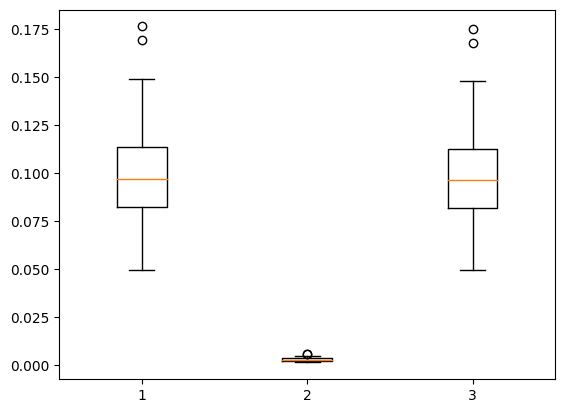

In [1191]:
%%time
#real_data = torch.randn(5000, 3)
#fake_data = torch.randn(5000, 3)
#sw_approx(real_data, fake_data), \
n = 100
b_t_m = torch.zeros(n)
bt_m = torch.zeros(n)
b_tm = torch.zeros(n)

for i in range(n):
    real_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 2], spatial_len=M, t_steps=t_steps)[:n_samples]
    fake_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 1.9], spatial_len=M, t_steps=t_steps)[:n_samples]
    b_t_m[i] = sw_approx(real_data, fake_data)
    bt_m[i] = sw_approx(real_data.view(n_samples*t_steps, -1 ), fake_data.view(n_samples*t_steps, -1 ))
    b_tm[i] = sw_approx(real_data.view(-1, t_steps* M ), fake_data.view(-1, t_steps* M ))
bt_m_1 = bt_m
print(f"b_t_m: {b_t_m.mean()}, bt_m: {bt_m.mean()}, b_tm: {b_tm.mean()}")
plt.boxplot([b_t_m, bt_m, b_tm]);

b_t_m: 0.35525694489479065, bt_m: 0.012324044480919838, b_tm: 0.35263001918792725
CPU times: user 19 s, sys: 3.43 s, total: 22.4 s
Wall time: 15.5 s


{'whiskers': [<matplotlib.lines.Line2D at 0x2a7af7a00>,
 'caps': [<matplotlib.lines.Line2D at 0x2a7b17be0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a7a907c0>,
 'medians': [<matplotlib.lines.Line2D at 0x2a7b17c70>,
 'fliers': [<matplotlib.lines.Line2D at 0x280a6fb50>,
 'means': []}

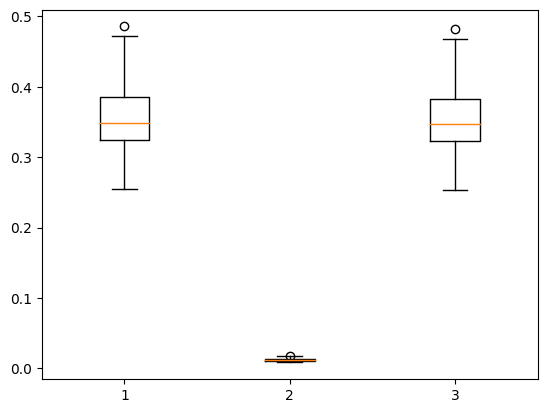

In [1192]:
%%time
#real_data = torch.randn(5000, 3)
#fake_data = torch.randn(5000, 3)
#sw_approx(real_data, fake_data), \
n = 100
b_t_m = torch.zeros(n)
bt_m = torch.zeros(n)
b_tm = torch.zeros(n)

for i in range(n):
    real_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 2], spatial_len=M, t_steps=t_steps)[:n_samples]
    fake_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 1.8], spatial_len=M, t_steps=t_steps)[:n_samples]
    b_t_m[i] = sw_approx(real_data, fake_data)
    bt_m[i] = sw_approx(real_data.view(n_samples*t_steps, -1 ), fake_data.view(n_samples*t_steps, -1 ))
    b_tm[i] = sw_approx(real_data.view(-1, t_steps* M ), fake_data.view(-1, t_steps* M ))
bt_m_2 = bt_m
print(f"b_t_m: {b_t_m.mean()}, bt_m: {bt_m.mean()}, b_tm: {b_tm.mean()}")
plt.boxplot([b_t_m, bt_m, b_tm]);

b_t_m: 0.949068546295166, bt_m: 0.04071445390582085, b_tm: 0.940825343132019
CPU times: user 19.1 s, sys: 3.44 s, total: 22.5 s
Wall time: 15.5 s


{'whiskers': [<matplotlib.lines.Line2D at 0x1745e30a0>,
 'caps': [<matplotlib.lines.Line2D at 0x17464fb80>,
 'boxes': [<matplotlib.lines.Line2D at 0x1745e3d90>,
 'medians': [<matplotlib.lines.Line2D at 0x1745dde50>,
 'fliers': [<matplotlib.lines.Line2D at 0x1745dd7c0>,
 'means': []}

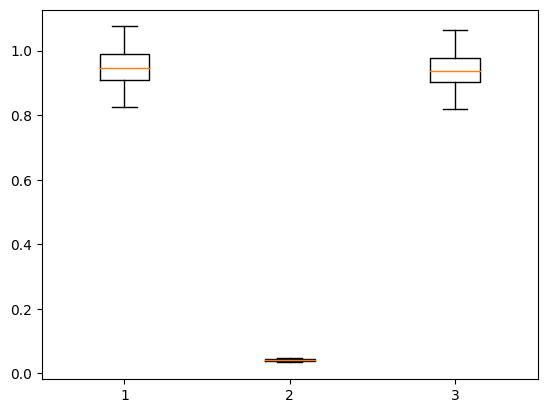

In [1193]:
%%time
#real_data = torch.randn(5000, 3)
#fake_data = torch.randn(5000, 3)
#sw_approx(real_data, fake_data), \
n = 100
b_t_m = torch.zeros(n)
bt_m = torch.zeros(n)
b_tm = torch.zeros(n)

for i in range(n):
    real_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 2], spatial_len=M, t_steps=t_steps)[:n_samples]
    fake_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 1.6], spatial_len=M, t_steps=t_steps)[:n_samples]
    b_t_m[i] = sw_approx(real_data, fake_data)
    bt_m[i] = sw_approx(real_data.view(n_samples*t_steps, -1 ), fake_data.view(n_samples*t_steps, -1 ))
    b_tm[i] = sw_approx(real_data.view(-1, t_steps* M ), fake_data.view(-1, t_steps* M ))
bt_m_3 = bt_m
print(f"b_t_m: {b_t_m.mean()}, bt_m: {bt_m.mean()}, b_tm: {b_tm.mean()}")
plt.boxplot([b_t_m, bt_m, b_tm]);

b_t_m: 1.9006553888320923, bt_m: 0.14986585080623627, b_tm: 1.8750561475753784
CPU times: user 19.1 s, sys: 3.45 s, total: 22.6 s
Wall time: 15.5 s


{'whiskers': [<matplotlib.lines.Line2D at 0x2a18fb2b0>,
 'caps': [<matplotlib.lines.Line2D at 0x291c8cac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2c42f8be0>,
 'medians': [<matplotlib.lines.Line2D at 0x2c4594c40>,
 'fliers': [<matplotlib.lines.Line2D at 0x2c4594220>,
 'means': []}

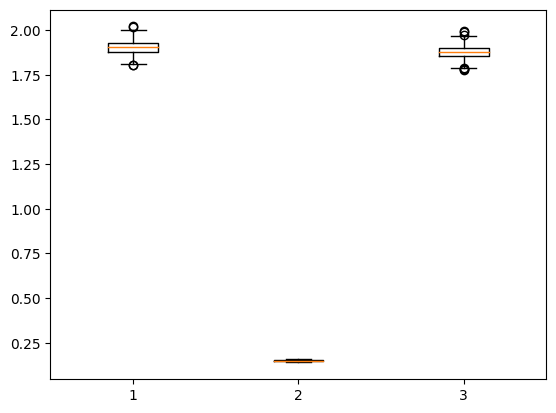

In [1194]:
%%time
#real_data = torch.randn(5000, 3)
#fake_data = torch.randn(5000, 3)
#sw_approx(real_data, fake_data), \
n = 100
b_t_m = torch.zeros(n)
bt_m = torch.zeros(n)
b_tm = torch.zeros(n)

for i in range(n):
    real_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 2], spatial_len=M, t_steps=t_steps)[:n_samples]
    fake_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 1], spatial_len=M, t_steps=t_steps)[:n_samples]
    b_t_m[i] = sw_approx(real_data, fake_data)
    bt_m[i] = sw_approx(real_data.view(n_samples*t_steps, -1 ), fake_data.view(n_samples*t_steps, -1 ))
    b_tm[i] = sw_approx(real_data.view(-1, t_steps* M ), fake_data.view(-1, t_steps* M ))
bt_m_4 = bt_m
print(f"b_t_m: {b_t_m.mean()}, bt_m: {bt_m.mean()}, b_tm: {b_tm.mean()}")
plt.boxplot([b_t_m, bt_m, b_tm]);

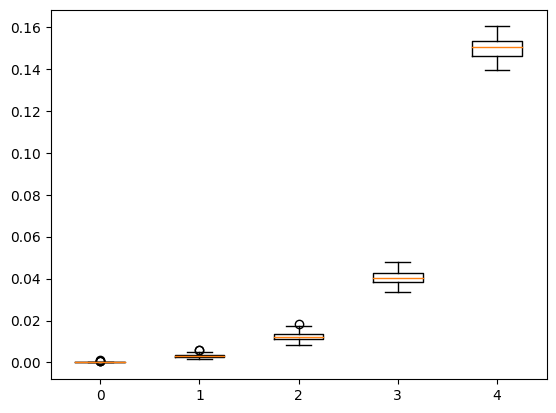

In [1195]:
plt.boxplot([bt_m_0, bt_m_1, bt_m_2, bt_m_3, bt_m_4], labels=["c2", "c1.9", "c1.8", "c1.6", "c1"]);

In [1197]:
torch.stack([bt_m_0, bt_m_1, bt_m_2, bt_m_3, bt_m_4]).mean(dim=1)

tensor([0.0002, 0.0031, 0.0123, 0.0407, 0.1499])